In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
from dateutil.parser import parse
from datetime import timedelta
from tqdm import tqdm

### 데이터 불러오기

In [73]:
data = pd.read_csv("data/0mA(19s)~80mA(1s)_NORMAL+EDLC.csv").iloc[:, :3]

### 기준 전압 인덱스 구하기

In [74]:
comm_A = np.where(data['Current(A)'] > 0.070) #통신 전류 인덱스 찾기

In [75]:
# 전압이 2V 이하인 통신 전류 데이터 인덱스가 없는 경우
if len(np.where(data['Voltage(V)'] < 2.000)[0]) == 0:
    print("false")
    comm_ = np.array(comm_A[0]) #comm_A[0]의 type이 tuple이기 때문에
    comm_ = np.array(comm_)

# 전압이 2V 이하인 통신 전류 데이터 인덱스가 있는 경우
else:
    print("true")
    comm_V_ = np.where(data['Voltage(V)'] < 2.000) #2v가 넘는 곳의 인덱스
    comm_V = np.array(comm_V_[0])
    comm_ = comm_A

    for i in comm_V:
        comm_ = np.delete(comm_, np.where(comm_ == i))

    comm_ = np.array(comm_)

true


#### 통신 전류 시작 인덱스 하나만

In [76]:
#첫 번째 인덱스는 넣어두고 시작
comm = np.array(comm_[0])

for idx in range(int(len(comm_))-1):
    #현재 값+1과 다음값이 같지 않으면 연속된 숫자가 아니라는 것으로 추가함
    if comm_[idx]+1 != comm_[idx+1]:
        comm = np.append(comm, comm_[idx+1])

#### 기준 전압은 통신 시작 전류 인덱스 바로 전

In [77]:
t_crit = comm - 1

#### 인덱스 조정: 전압이 떨어지는 순간부터
- 전류는 통신 전류가 아닌데 전압이 떨어지는 순간이 있는데 그렇게 되면 전압 변화율이 이상하게 계산됨

In [78]:
#최종 기준 전압 인덱스가 저장되는 배열
ref = np.array([], dtype=int)


for t in tqdm(t_crit):
    tmp = t  #t_crit에서 가져오는 각 인덱스들
    
    for i in range(1, 5): #4번 loop
        #전압(+): t < t-1
        if (data['Voltage(V)'][tmp] < data['Voltage(V)'][t-i]):
            #t-1 > t-2 => 인덱스 변경: t-i
            if data['Voltage(V)'][t-i] >= data['Voltage(V)'][t-i-1]: #이전 이전의 전압이 더 작으면
                tmp = t-i
                break
            else: #인덱스 옮기면서 계속 찾기
                tmp = t- i
        #전압 (-), 전류 (+) => 인덱스 변경: t-i
        elif (data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]) and (data['Current(A)'][tmp] < data['Current(A)'][t-i]) and (data['Current(A)'][tmp] != 0.0000) and (data['Current(A)'][t-i] > 0.070):
            tmp = t-i
        #전압(-) => 인덱스 유지
        elif data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]:
            break
        #전압이 같음: t == t-1
        elif data['Voltage(V)'][tmp] == data['Voltage(V)'][t-i]:
            #t-1 < t-2 => 인덱스 변경: t-i-1
            if data['Voltage(V)'][t-i] < data['Voltage(V)'][t-i-1]:
                tmp = t-i-1
                break
            
    ref = np.append(ref, tmp)
            
#중간에 값이 겹치는 부분이 있을 수 있음 -> 중복되는 값 제거
ref = np.unique(ref)

100%|██████████████████████████████████████████████████████████████████████████| 21198/21198 [00:02<00:00, 8989.22it/s]


### 전압 회복 시간, 전압 변화율, 전압(기준 전압, 회복 전압)을 확인하기 위함
- recovery_time [[기준 전압 시각, 회복 전압 시각]]
- recovery_rate [[최대 전압 변화율, 회복 전압 변화율]]
- recovery_volt [[기준 전압, 통신 중 최소 전압, 회복 전압]]
- crit = 회복 전압으로 보는 기준 전압 변화율
- np.delete()하는 이유는 처음에 np.zeros(())로 만들었기 때문에 제일 처음에 0 값이 들어가 있음
    - np.empty(())를 사용하면 쓰레기 값이 들어가 있음 (어차피 같음)

In [90]:
recovery_time=np.zeros((1,2)) #통신 전, 회복(crit) 시간
recovery_rate=np.zeros((1,2), dtype=int) #통신(최대), crit(0.5 or smaller)
recovery_volt=np.zeros((1,3), dtype=int) #통신전, 통신(최소), 회복
index = np.zeros((1,2))

crit = 0.50

for _, i in enumerate(tqdm(ref)): #기준 전압 인덱스가 i
    
    r = np.array([]) #전압 변화율은 최댓값을 구해야 함
    v = np.array([]) #전압 값은 최솟값을 구해야 함
    
    for j in range(1, int(len(data['Voltage(V)']))): #기준 전압 인덱스와 그 다음 인덱스부터 비교해야 하기 때문에 1부터 시작
        
        rate = (data['Voltage(V)'][i] - data['Voltage(V)'][i+j])/data['Voltage(V)'][i] * 100 #(기준전압 - 현재전압)/기준전압 *100
        r = np.append(r, np.array([rate])) #배열에 위에서 구한 전압 변화율 추가
        v = np.append(v, np.array([data['Voltage(V)'][i+j]])) #배열에 현재 전압값 추가

        #회복 전압이면 반복을 멈추고 각 배열에 요소 추가
        # 1. 현재 전압 < 다음 전압 && 2. 다음 전류가 0.020보다 작을 때 && 3. 현재 전압 변화율 <= 기준 전압 변화율 && 4. 전압 변화율 != 0
        if (data['Voltage(V)'][i+j] < data['Voltage(V)'][i+j+1]) and (data['Current(A)'][i+j+1] < 0.020) and (rate <= crit) and (rate != 0.0000):
            #전압 변화율 추가(최대 전압 변화율(최저 전압), 현재 전압 변화율)
            recovery_rate = np.append(recovery_rate, np.array([np.max(r), rate]).reshape(1,2), axis=0)
            #전압 회복 시간(기준 전압 시간, 회복 전압 시간)
            recovery_time = np.append(recovery_time, np.array([data['Time'][i], data['Time'][i+j]]).reshape(1,2), axis=0)
            #전압(기준 전압, 최저 전압, 회복 전압)
            recovery_volt = np.append(recovery_volt, np.array([data['Voltage(V)'][i], np.min(v), data['Voltage(V)'][i+j]]).reshape(1,3), axis=0)

            index = np.append(index, np.array([i, (i+j)]).reshape(1,2), axis=0)
            break
            
recovery_rate = np.delete(recovery_rate, 0, 0)
recovery_time = np.delete(recovery_time, 0, 0)
recovery_volt = np.delete(recovery_volt, 0, 0)
index = np.delete(index, 0, 0)

100%|███████████████████████████████████████████████████████████████████████████| 21198/21198 [00:49<00:00, 426.30it/s]


### 시간을 timedelt로 변환하기 위함
- 전압 회복 시간을 구하기 위해서 timedelt로 변환해야 계산 가능

In [80]:
date_=[] #replace korean to english

for i in recovery_time.flatten():
    i = i.replace("오전", "AM")
    i = i.replace("오후", "PM")
    date_.append(i)
    
date__=[] #split blank

for i in date_:
    date__.append(i.split(" "))
    
date___=[] #switch index

for i in date__: #위치 변경
    tmp = i[1] 
    i[1] = i[2]
    i[2] = tmp
    date___.append(i)
    
parsing_date=[]

for i in tqdm(date___):
    #print('parsing: ', i, "=", (" ").join(i))
    dt = parse((" ").join(i)) #list to string
    #print(dt)
    #print()
    parsing_date.append(dt)
    
recovery_time = np.array(parsing_date).reshape(recovery_time.shape[0], 2)

100%|██████████████████████████████████████████████████████████████████████████| 42396/42396 [00:04<00:00, 9911.52it/s]


### 그래프를 그려 변화 확인

*normal+EDLC*

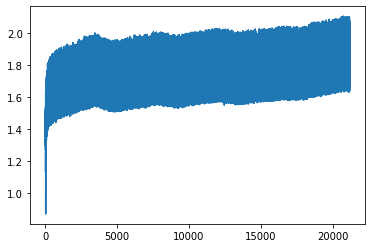

In [81]:
plt.plot(np.max(recovery_rate[:], axis=1))

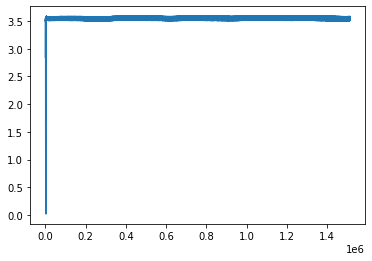

In [82]:
plt.plot(data['Voltage(V)'][:])

*normal_30mA*

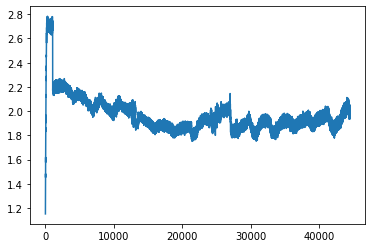

In [62]:
plt.plot(np.max(recovery_rate[:], axis=1))

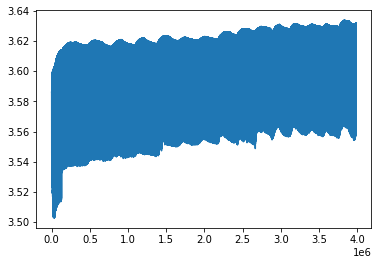

In [63]:
plt.plot(data['Voltage(V)'][:])

#### 전압 회복 시간

In [83]:
re_time = np.array([])
for i in recovery_time:
    re_time = np.append(re_time, np.array((i[1]-i[0]).seconds))

In [91]:
recovery_volt[20000]

array([3.5806, 3.5221, 3.5631])

In [92]:
recovery_time[20000]

array(['2021-11-09 오전 4:27:23', '2021-11-09 오전 4:27:30'], dtype='<U32')

In [93]:
index[20000]

array([1439217., 1439237.])

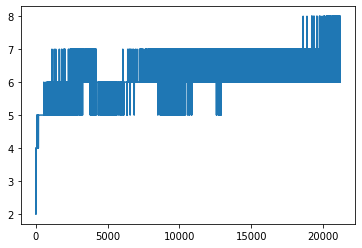

In [84]:
plt.plot(re_time)

*평균 전압 회복 시간*

In [72]:
np.average(re_time) #normal_30mA

1.438577149799757

In [85]:
np.average(re_time) #normal+edls 80mA

6.117086517595999

#### 전압 회복 시간, 최대 전압 변화율 저장